## BYOL for image segmentation

Example with UNet model from [segmentation-models-pytorch](https://github.com/qubvel/segmentation_models.pytorch/tree/master).

In [1]:
import sys

sys.path.append("./../")

from byol.models import BYOL, UNETModule
from byol.utils import BYOLTransforms1, BYOLTransforms
import torch
import pytorch_lightning as pl
import torchvision
import numpy as np

accelerator = "gpu" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from utils.oxford_pet import SimpleOxfordPetDataset, BYOLOxfordPetDataset
import os
from torch.utils.data import DataLoader

root = "."
#SimpleOxfordPetDataset.download(root)
# init train, val, test sets
train_dataset = SimpleOxfordPetDataset(root, "train")
valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(root, "test")

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

Train size: 3312
Valid size: 368
Test size: 1834


### Training an UNET model on the SimpleOxfordPet Dataset

In [3]:
unet_module = UNETModule(encoder_name="resnet50")

unet_trainer = pl.Trainer(
    max_epochs=10,
    accelerator=accelerator,
    devices=1,
)

unet_trainer.fit(unet_module, train_dataloader, valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------------------------------------------------
0 | model          | Unet            | 32.5 M
1 | loss_fn        | DiceLoss        | 0     
2 | validation_iou | SegmentationIOU | 0     
3 | training_iou   | SegmentationIOU | 0     
4 | test_iou       | SegmentationIOU | 0     
---------------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


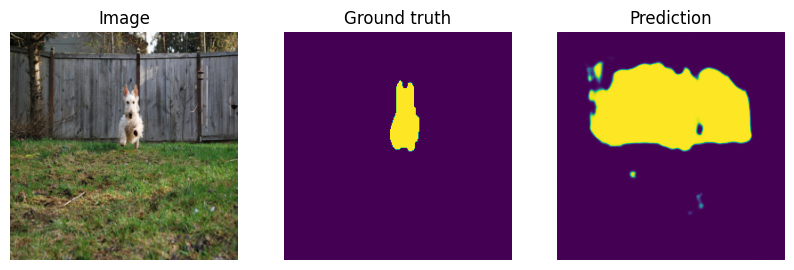

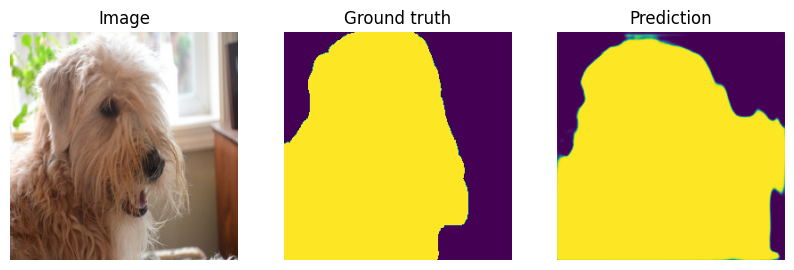

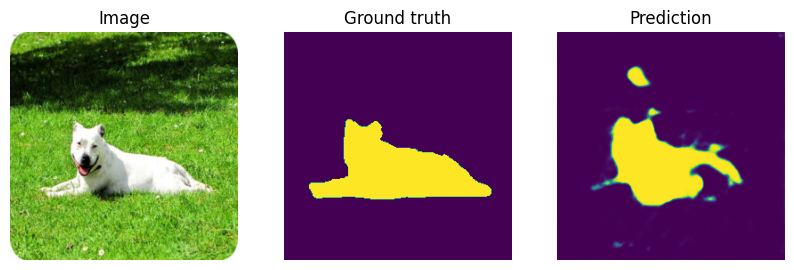

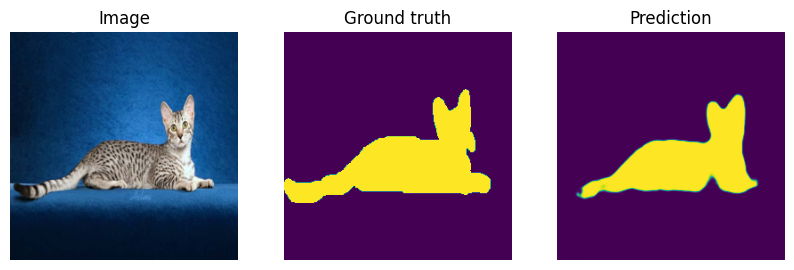

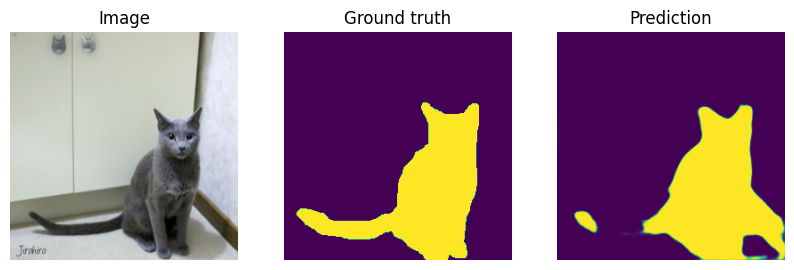

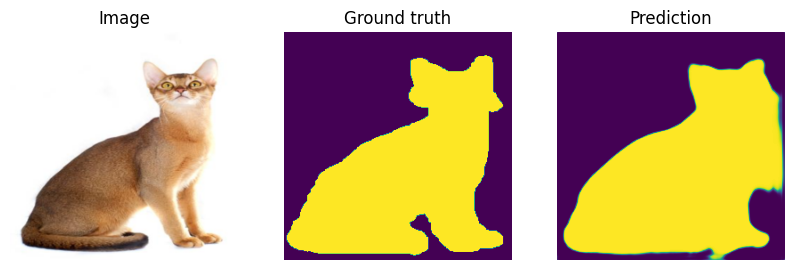

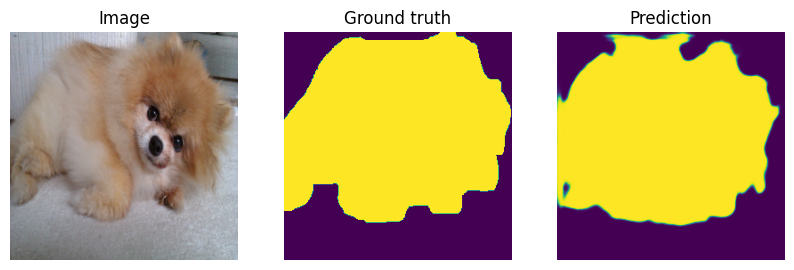

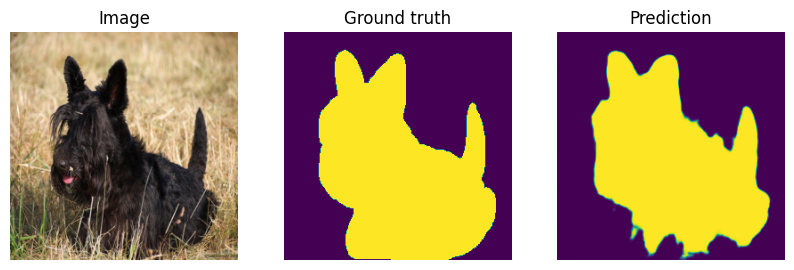

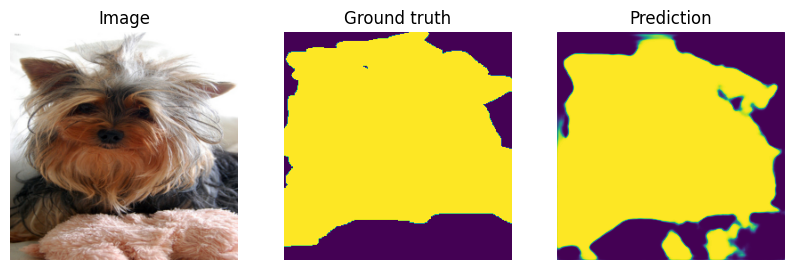

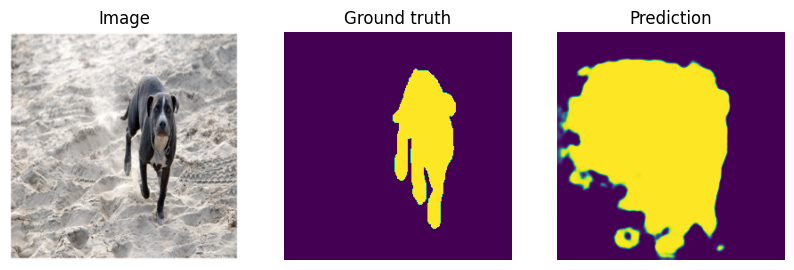

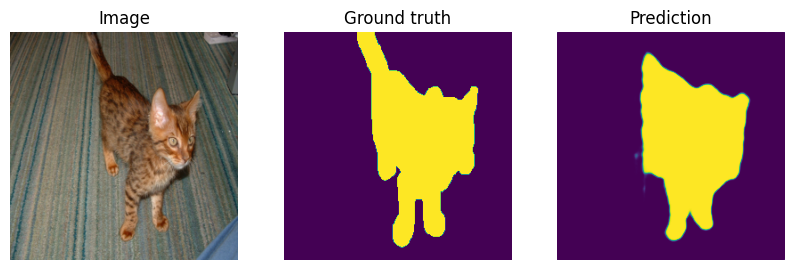

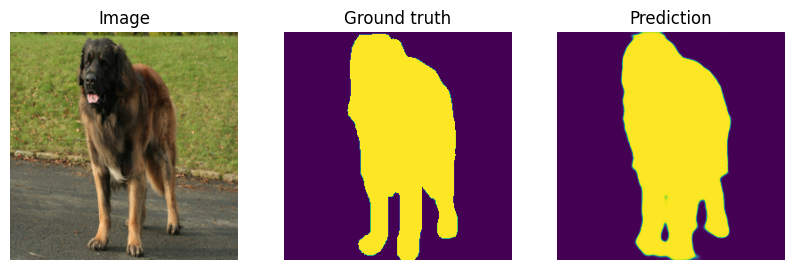

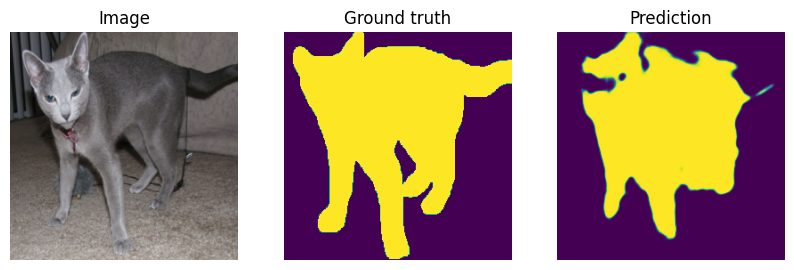

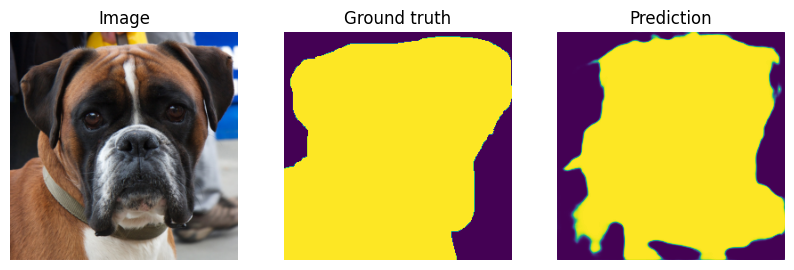

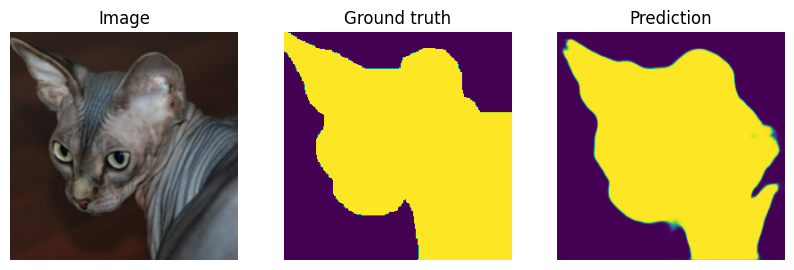

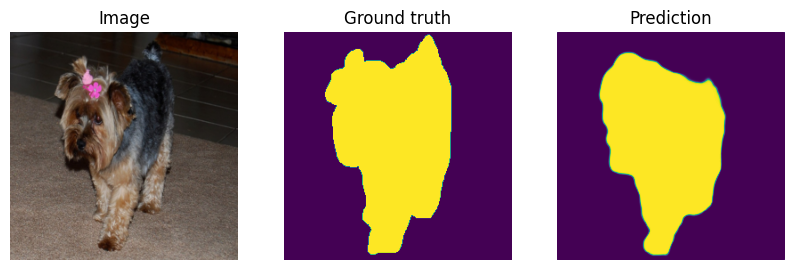

In [4]:
import matplotlib.pyplot as plt

batch = next(iter(test_dataloader))
with torch.no_grad():
    unet_module.eval()
    logits = unet_module(batch["image"].float())
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()
     

### Training BYOL on SimpleOxfordPet Dataset

In [5]:
transform = BYOLTransforms(
    view1=BYOLTransforms1(input_size=256),
    view2=BYOLTransforms1(input_size=256)
)
byol_dataset = BYOLOxfordPetDataset(root, "byol", transform=transform)

byol_dataloader = DataLoader(byol_dataset, batch_size=512, shuffle=True, num_workers=n_cpu)
byol_module = BYOL(
    hparams={
        "input_dim": 2048,
        "hidden_dim": 4096,
        "projection_dim": 256,
        "max_epochs": 25, # used for the cosine scheduler
    },
    model=unet_module.model.encoder,
    batch_type="dict",
)


In [6]:
byol_trainer = pl.Trainer(
    max_epochs=25,
    devices=1,
    accelerator=accelerator,
)

byol_trainer.fit(model=byol_module, train_dataloaders=byol_dataloader) # our model never sees labeled data!

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type               | Params
--------------------------------------------------------------
0 | backbone               | Sequential         | 23.5 M
1 | target_backbone        | Sequential         | 23.5 M
2 | projection_head        | BYOLProjectionHead | 9.4 M 
3 | prediction_head        | BYOLPredictionHead | 2.1 M 
4 | target_projection_head | BYOLProjectionHead | 9.4 M 
5 | loss                   | CosineSimilarity   | 0     
--------------------------------------------------------------
11.6 M    Trainable params
33.0 M    Non-trainable params
44.5 M    Total params
178.020   Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interva

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


### Fine-tuning our BYOL-boosted-UNET on the rest of the dataset.

In [7]:
byol_module.backbone.state_dict().keys() == unet_module.model.encoder.state_dict().keys()

True

In [8]:
unet_byol_module = UNETModule.from_byol(byol_module, encoder_name="resnet50")

unet_byol_trainer = pl.Trainer(
    max_epochs=10,
    accelerator=accelerator,
    devices=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
unet_byol_trainer.fit(unet_byol_module, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------------------------------------------------
0 | model          | Unet            | 32.5 M
1 | loss_fn        | DiceLoss        | 0     
2 | validation_iou | SegmentationIOU | 0     
3 | training_iou   | SegmentationIOU | 0     
4 | test_iou       | SegmentationIOU | 0     
---------------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.084   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


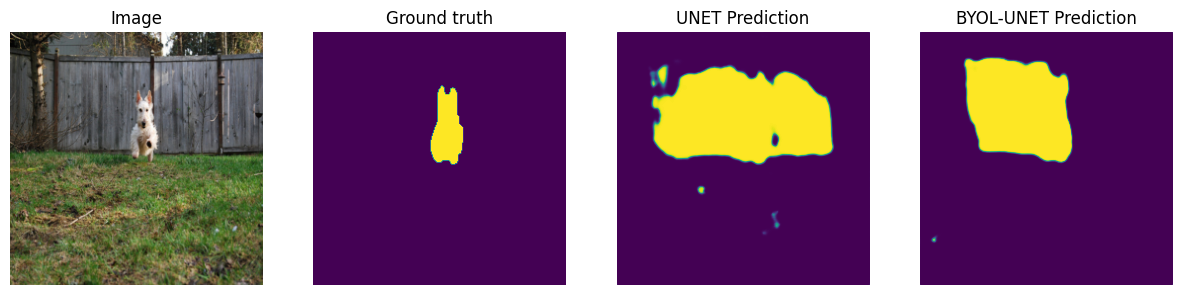

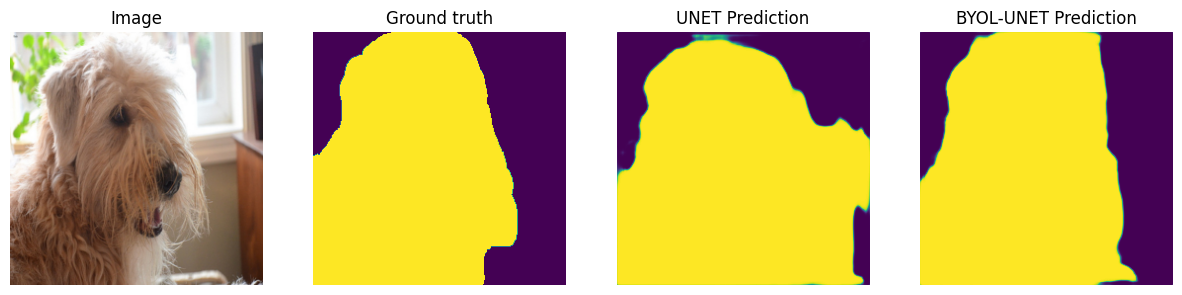

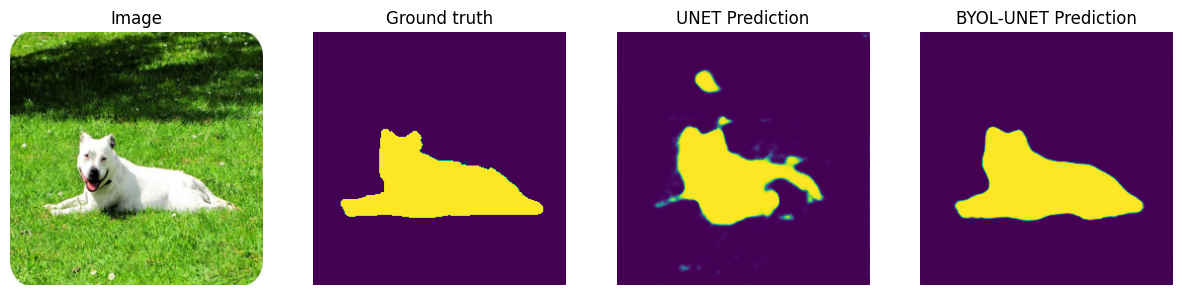

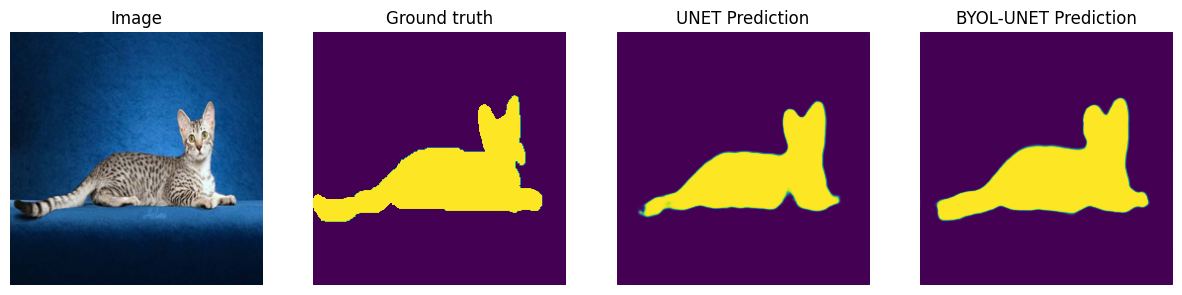

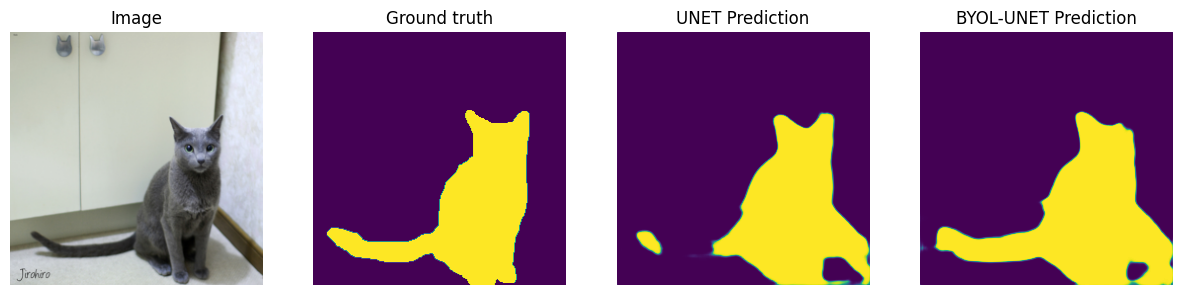

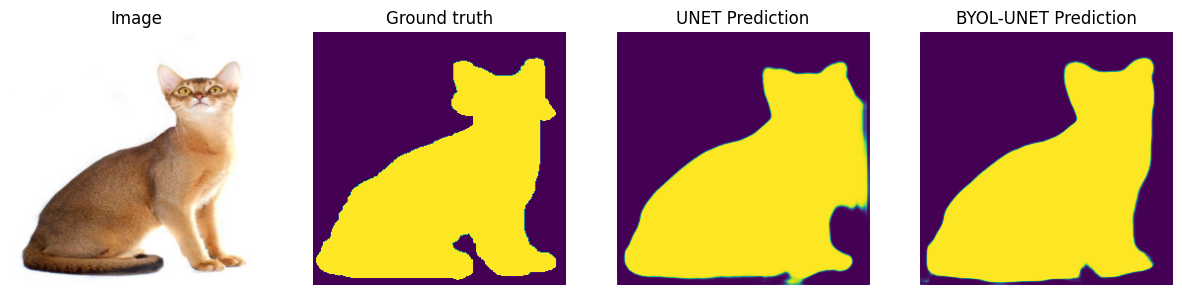

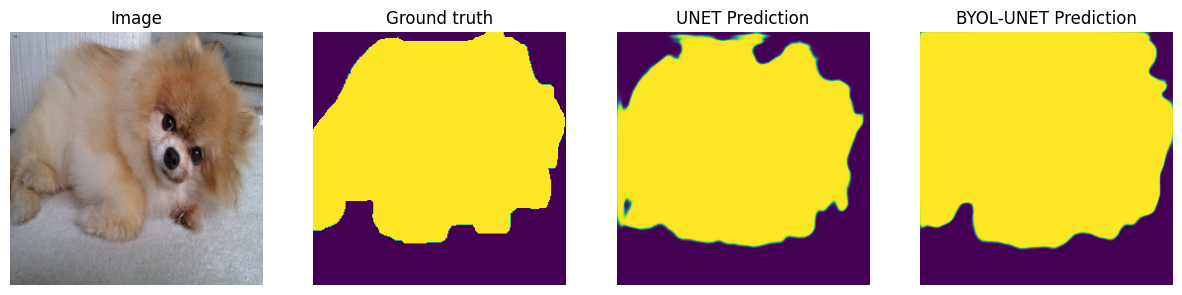

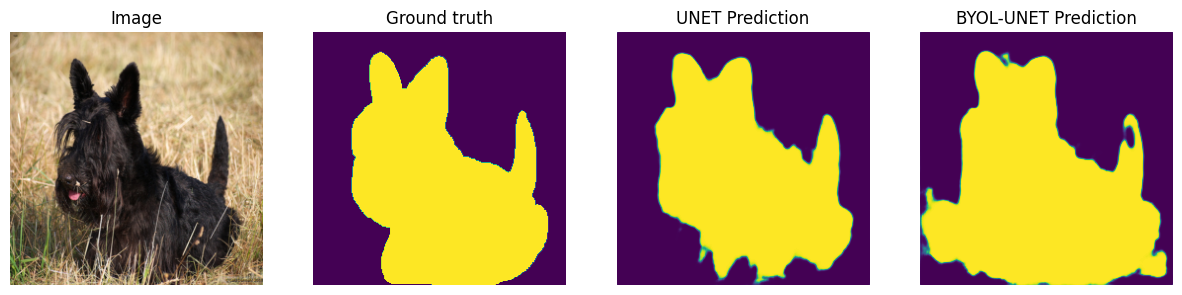

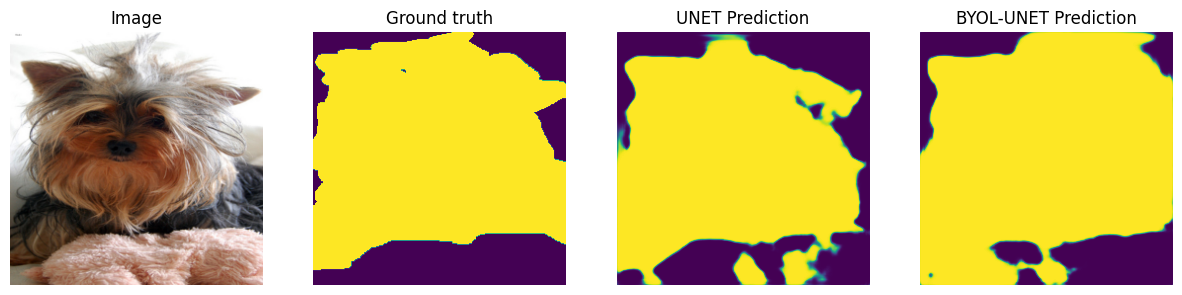

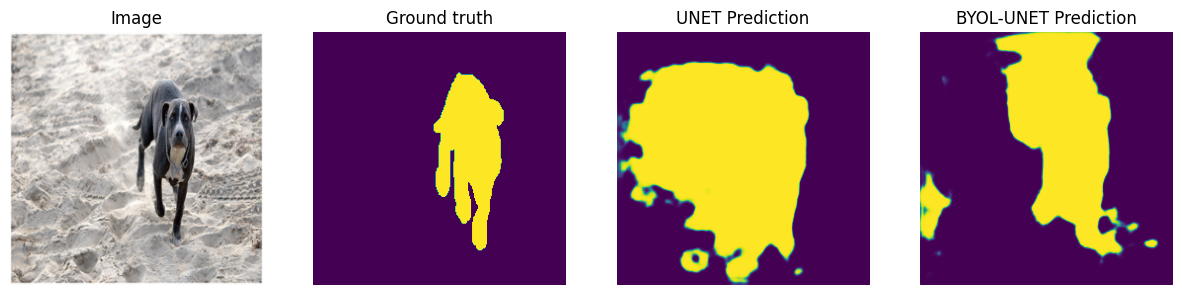

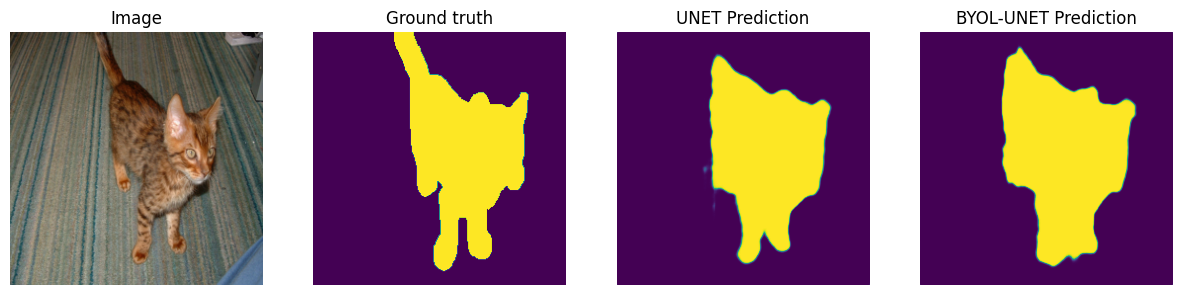

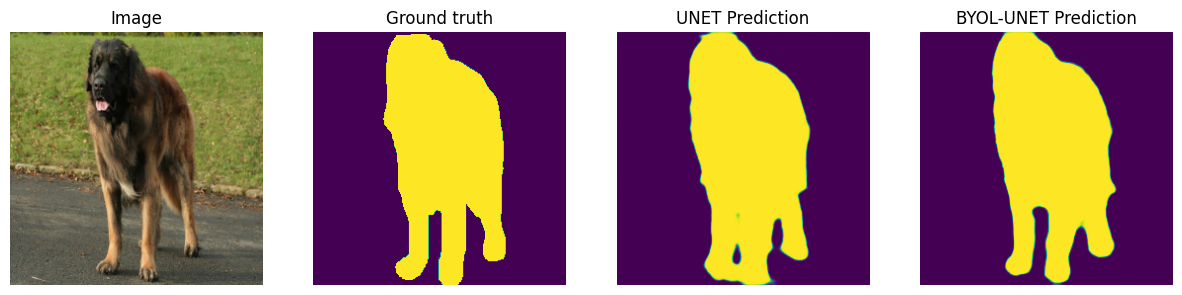

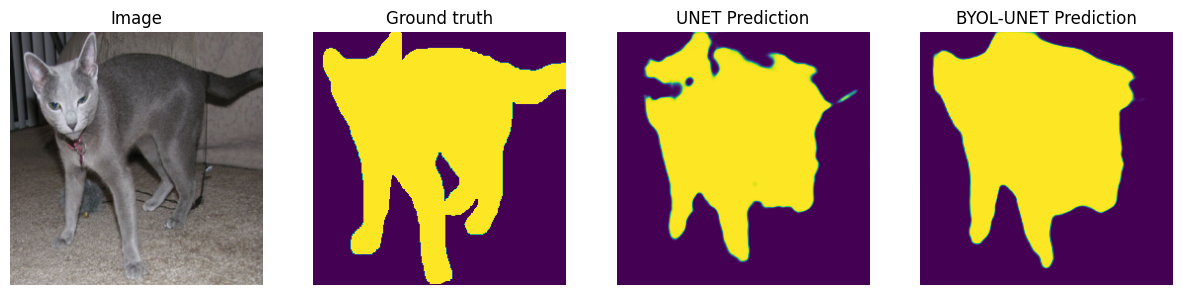

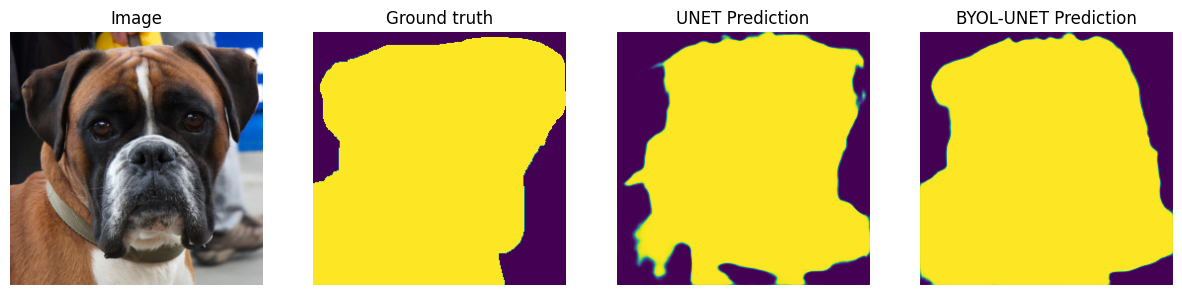

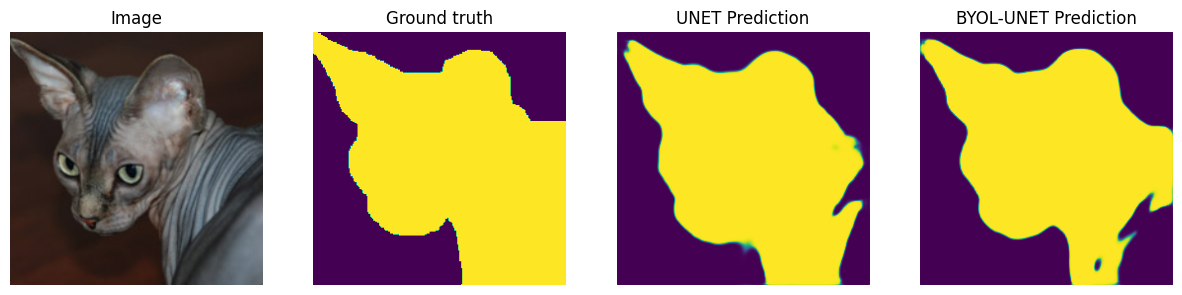

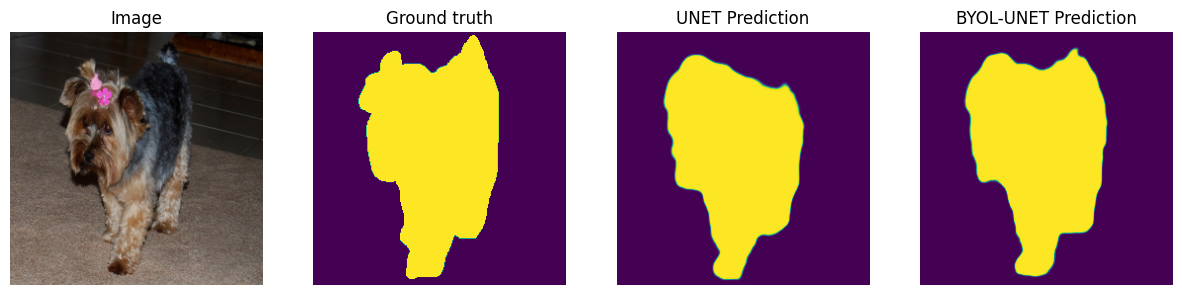

In [10]:
import matplotlib.pyplot as plt

batch = next(iter(test_dataloader))
with torch.no_grad():
    unet_module.eval()
    logits = unet_module(batch["image"].float())

with torch.no_grad():
    unet_byol_module.eval()
    logits_byol = unet_byol_module(batch["image"].float())

pr_masks_unet = logits.sigmoid()
pr_masks_byol = logits_byol.sigmoid()

for image, gt_mask, pr_mask_unet, pr_mask_byol in zip(batch["image"], batch["mask"], pr_masks, pr_masks_byol):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(pr_mask_unet.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("UNET Prediction")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(pr_mask_byol.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("BYOL-UNET Prediction")
    plt.axis("off")

    plt.show()
     

In [11]:
unet_trainer.test(unet_module, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_iou          │    0.7414513826370239     │
└───────────────────────────┴───────────────────────────┘

[{'test_iou': 0.7414513826370239}]

In [12]:
unet_trainer.test(unet_byol_module, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_iou          │    0.7754998803138733     │
└───────────────────────────┴───────────────────────────┘

[{'test_iou': 0.7754998803138733}]

In [13]:
# import torch.nn as nn

# unet_module = UNETModule(encoder_name="resnet50")
# m = nn.Sequential(*list(unet_module.model.encoder.children()), nn.AdaptiveAvgPool2d((1, 1)))
# m.eval()
# x = torch.rand(1, 3, 32, 32)
# m(x).flatten(start_dim=1).shape

In [14]:
# import torchvision.models as models

# resnet = models.resnet18(pretrained=False, num_classes=10)
# m = nn.Sequential(*list(resnet.children())[:-1])
# m.eval()
# x = torch.rand(1, 3, 256, 256)
# m(x).flatten(start_dim=1).shape